# 240. CIFAR-10 을 이용한 CNN 구축

- **CNN**을 학습하여 CIFAR-10 데이터베이스의 이미지를 분류합니다.

<img src='https://production-media.paperswithcode.com/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg' width=600 />


- mean, std ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 로 normalize 된 image 의 unnormalization 방법
    - image = image * 0.5 + 0.5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
BATCH_SIZE = 32
lr = 0.01

## Data Download 및 Data Loader 를 이용하여 Train, Validation data 준비

In [5]:
# image augmentation
composed = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))   # (mean, std)
                                    ])

train_data = datasets.CIFAR10(root='./data', 
                train=True, download=True, transform=composed)                
test_data  = datasets.CIFAR10(root='./data', 
                train=False, download=True, transform=composed)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [18]:
print(train_data)
print()
print(test_data)
print()
print(train_data[0][0].shape)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

torch.Size([3, 32, 32])


In [12]:
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### 일부 Data 시각화

- matplotlib 은 channel 위치가 last 이므로 transpose(1, 2, 0) 로 image 수정

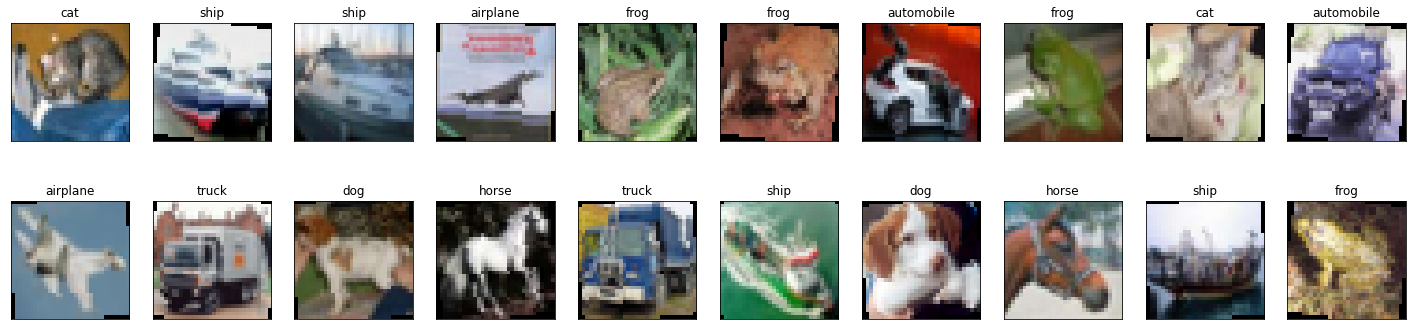

In [13]:
plt.figure(figsize=(25, 6))
for i, (x, y) in enumerate(test_data):
    if i > 19:
        break
    plt.subplot(2, 10, i+1)
    img = np.transpose(x, (1, 2, 0)) * 0.5 + 0.5    # unnormalize
    plt.imshow(img)  
    plt.title(cifar10_classes[y])
    plt.xticks([])
    plt.yticks([])

plt.show()

## Model build

### Custom Model

- Output Size = (W - F + 2P) / S + 1  
- output_size / Maxpool(2) 

In [24]:
def output_size(W, F, P, S, poolsize=1):
    size = (W - F + 2*P)/S + 1
    return size if poolsize == 1 else size / poolsize

In [25]:
out1 = output_size(32, 3, 1, 1, poolsize=2)
print(out1)
out2 = output_size(out1, 3, 1, 1, poolsize=2)
print(out2)
out3 = output_size(out2, 3, 1, 1, poolsize=2)
out3

16.0
8.0


4.0

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(4*4*64 , 256)  #((W - F + 2P) / S + 1)/pool size
        self.fc1_bn = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 10)
        self.maxpool = nn.MaxPool2d(2)  #pool size = 2
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.relu(self.conv1_bn(self.conv1(x)))
        x = self.maxpool(x) 
        x = self.relu(self.conv2_bn(self.conv2(x)))
        x = self.maxpool(x)
        x = self.relu(self.conv3_bn(self.conv3(x)))
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.relu(self.fc1_bn(self.fc1(x)))
        out = self.fc2(x)
        return out

In [29]:
model = Net()
model = model.to(device)

### nn.Sequential 이용


- ``torch.nn`` 에는 코드를 간단히 사용할 수 있는 또 다른 편리한 클래스인
[Sequential](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential) 이 있습니다.  

- ``Sequential`` 객체는 그 안에 포함된 각 모듈을 순차적으로 실행합니다. 이것은 신경망을 작성하는 더 간단한 방법입니다.


In [31]:
model_sequential = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), 

    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), 

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), 

    nn.Flatten(), 
    nn.Dropout(0.25),
    nn.Linear(1024, 256),  
    nn.BatchNorm1d(256),
    nn.Linear(256, 10) # output: bs x 10 
)

### Model Summary

In [32]:
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc1_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

In [37]:
model_sequential

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Dropout(p=0.25, inplace=False)
  (14): Linear(in_features=1024, out_features=256, bias=True)
  (15): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

In [42]:
print("model parameters :", sum(p.numel() for p in model.parameters()))

print("model_sequential parameters :", sum(p.numel() for p in model_sequential.parameters()))

model parameters : 289290
model_sequential parameters : 289290


### Loss Function

In [43]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [44]:
LOSS, VAL_LOSS, ACC, VAL_ACC = [], [], [], []

EPOCHS = 30

for epoch in range(EPOCHS):
    
    model.train()  # train mode
    
    train_loss = 0
    train_acc = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        train_loss += loss.item()
        _, y_pred = torch.max(z, 1)
        train_acc += (y_pred == y).sum().item()

        loss.backward()
        optimizer.step()


    train_loss = train_loss/len(train_data)
    train_acc = train_acc / len(train_data) 
    LOSS.append(train_loss)
    ACC.append(train_acc)
    
    model.eval()   # evaluation mode
        
    val_loss = 0
    val_acc = 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        
        z = model(x)
        loss = criterion(z, y)

        val_loss += loss.item()
        _, y_pred = torch.max(z, 1)
        val_acc += (y_pred == y).sum().item()
        
    val_loss = val_loss / len(test_data)
    val_acc = val_acc / len(test_data)
    VAL_LOSS.append(val_loss)
    VAL_ACC.append(val_acc)
    
    print(f'epoch {epoch} ==> train loss: {train_loss:.5f},  valididation loss: {val_loss:.5f}',  
                                            f'train acc: {train_acc:.5f}, validation acc: {val_acc:.5f}')

epoch 0 ==> train loss: 0.04734,  valididation loss: 0.03928 train acc: 0.45468, validation acc: 0.55290
epoch 1 ==> train loss: 0.03837,  valididation loss: 0.03402 train acc: 0.56200, validation acc: 0.61410
epoch 2 ==> train loss: 0.03471,  valididation loss: 0.03102 train acc: 0.60408, validation acc: 0.64390
epoch 3 ==> train loss: 0.03219,  valididation loss: 0.02930 train acc: 0.63420, validation acc: 0.66590
epoch 4 ==> train loss: 0.03070,  valididation loss: 0.02643 train acc: 0.65238, validation acc: 0.70980
epoch 5 ==> train loss: 0.02908,  valididation loss: 0.02619 train acc: 0.67038, validation acc: 0.70970
epoch 6 ==> train loss: 0.02780,  valididation loss: 0.02573 train acc: 0.68768, validation acc: 0.71100
epoch 7 ==> train loss: 0.02691,  valididation loss: 0.02630 train acc: 0.69526, validation acc: 0.70640
epoch 8 ==> train loss: 0.02617,  valididation loss: 0.02438 train acc: 0.70660, validation acc: 0.73070
epoch 9 ==> train loss: 0.02548,  valididation loss: 0.

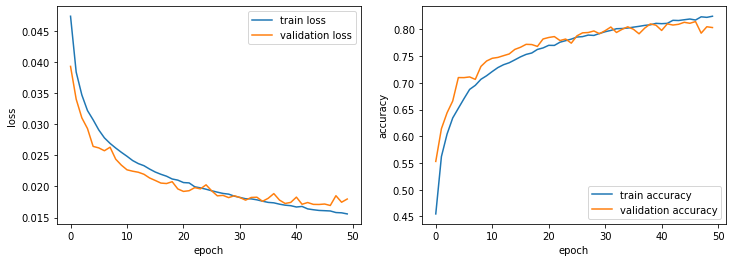

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(LOSS, label='train loss')
ax1.plot(VAL_LOSS, label='validation loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
ax2.plot(ACC, label='train accuracy')
ax2.plot(VAL_ACC, label='validation accuracy')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()

### Model 평가

### model 이 어떤 image 들을 잘 맞추고 혹은 틀렸는지 시각화

In [46]:
predictions = []
labels = []

model.eval()

for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    z = model(x)
    _, y_pred = torch.max(z, 1)
    predictions.extend(y_pred.cpu().numpy())
    labels.extend(y.cpu().numpy())
    
correct_indices = np.nonzero(np.array(predictions) == np.array(labels))[0]
incorrect_indices = np.nonzero(np.array(predictions) != np.array(labels))[0]
    
print("accuracy = {:.2f}%".format(len(correct_indices) / len(predictions) * 100))

accuracy = 80.70%


Text(51.0, 0.5, 'Predicted Value')

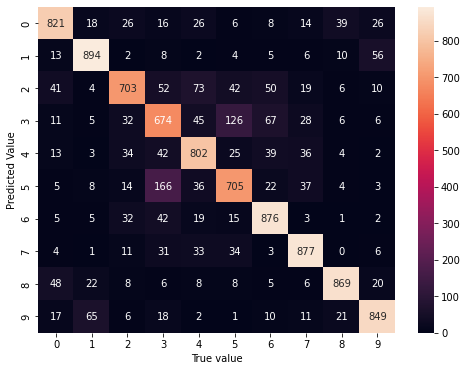

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set_xlabel('True value')
ax.set_ylabel('Predicted Value')

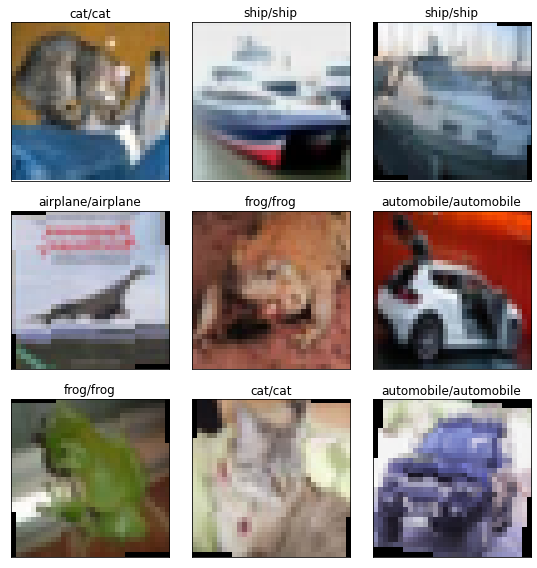

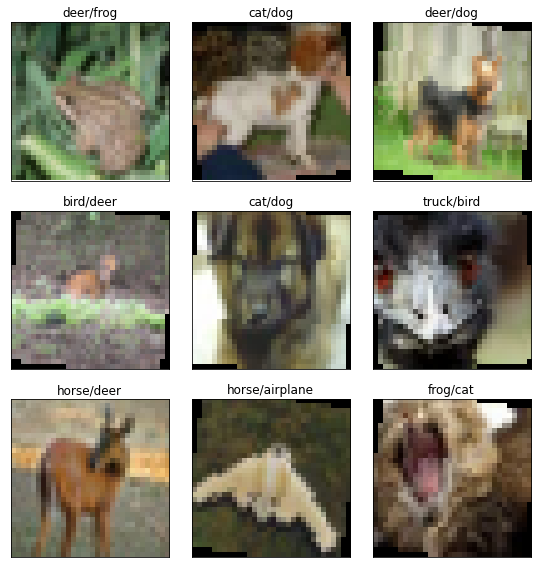

In [48]:
plt.figure(figsize=(8, 8))
for i, idx in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i+1)
    img = np.transpose(test_data[idx][0], (1, 2, 0)) / 2 + 0.5  
    plt.imshow(img, cmap='gray')
    plt.title("{}/{}".format(cifar10_classes[predictions[idx]], cifar10_classes[labels[idx]]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

plt.figure(figsize=(8, 8))
for i, idx in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i+1)
    img = np.transpose(test_data[idx][0], (1, 2, 0)) / 2 + 0.5  
    plt.imshow(img, cmap='gray')
    plt.title("{}/{}".format(cifar10_classes[predictions[idx]], cifar10_classes[labels[idx]]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Saving and loading the model

### Save and load the model via state_dict

In [ ]:
PATH = 'cifar10-cnn.pth'
torch.save(model.state_dict(), PATH)

In [ ]:
model = Net()
model.load_state_dict(torch.load(PATH))
model.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc1_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
z = model(next(iter(test_loader))[0])
_, y_pred = torch.max(z, 1)

print(y_pred)
print(next(iter(test_loader))[1])

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 9, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6])
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6])


### Save and load entire model

In [ ]:
PATH = "entire_model.pt"
# Save
torch.save(model, PATH)

In [ ]:
# Load
model = torch.load(PATH)
model.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc1_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
z = model(next(iter(test_loader))[0])
_, y_pred = torch.max(z, 1)

print(y_pred)
print(next(iter(test_loader))[1])

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 3, 7, 9, 8, 5, 7, 8, 6])
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6])
